In [ ]:
# import urllib.request

# url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
# week_nums = [210109, 210116, 210123, 210130, 210206, 210213, 210220, 210227, 210306, 210313, 210320,
# 210327, 210403, 210410, 210417]

# for week_num in week_nums:
#     urllib.request.urlretrieve(f"http://web.mta.info/developers/data/nyct/turnstile/turnstile_{week_num}.txt",
#                                f"data/turnstile_{week_num}.txt")

In [166]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [178]:
engine = create_engine("sqlite:///mta.db")
all_data = pd.read_sql('with mta as(select *, row_number() over (PARTITION by CA, UNIT,  STATION,  SCP, date, time order by CA, UNIT,  STATION,  SCP, date, time) as dupes from mta_data) select *, case when (time between "08:00:00" and "11:00:00" ) then "Morning rush" when (time between "18:00:00" and "22:00:00" ) then "Evening rush" else "" end as rush_hour, LAG ( entries, 1, 0 ) OVER ( partition by CA, UNIT,  STATION,  SCP ORDER BY date, time)  as entered, LAG ( exits, 1, 0 ) OVER ( partition by CA, UNIT,  STATION,  SCP ORDER BY date, time) as exited from mta where dupes = 1;', engine)

In [179]:
# Converting the text date into an actual date value
all_data['DOW'] = pd.to_datetime(all_data['DATE'])

# Converting the new date value into a Day of Week format
all_data['DOW1'] = all_data['DOW'].dt.strftime('%a')
all_data['week_num'] = all_data['DOW'].dt.strftime('%V').astype(int)


In [180]:
mask = (all_data['STATION'] == '5 AV/53 ST')
all_data[mask].head(75)

,CA,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,dupes,rush_hour,entered,exited,DOW,DOW1,week_num
1188828,N303,R015,00-00-00,5 AV/53 ST,EM,IND,01/02/2021,01:00:00,REGULAR,14521186,31671631,1,,0,0,2021-01-02,Sat,53
1188829,N303,R015,00-00-00,5 AV/53 ST,EM,IND,01/02/2021,05:00:00,REGULAR,14521186,31671633,1,,14521186,31671631,2021-01-02,Sat,53
1188830,N303,R015,00-00-00,5 AV/53 ST,EM,IND,01/02/2021,09:00:00,REGULAR,14521186,31671634,1,Morning rush,14521186,31671633,2021-01-02,Sat,53
1188831,N303,R015,00-00-00,5 AV/53 ST,EM,IND,01/02/2021,13:00:00,REGULAR,14521186,31671634,1,,14521186,31671634,2021-01-02,Sat,53
1188832,N303,R015,00-00-00,5 AV/53 ST,EM,IND,01/02/2021,17:00:00,REGULAR,14521186,31671634,1,,14521186,31671634,2021-01-02,Sat,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1188898,N303,R015,00-00-00,5 AV/53 ST,EM,IND,01/13/2021,17:00:00,REGULAR,14524709,31684896,1,,14524492,31684687,2021-01-13,Wed,2
1188899,N303,R015,00-00-00,5 AV/53 ST,EM,IND,01/13/2021,21:00:00,REGULAR,14524919,31684953,1,Evening rush,14524709,31684896,2021-01-13,Wed,2
1188900,N303,R015,00-00-00,5 AV/53 ST,EM,IND,01/14/2021,01:00:00,REGULAR,14524931,31684982,1,,14524919,31684953,2021-01-14,Thu,2
1188901,N303,R015,00-00-00,5 AV/53 ST,EM,IND,01/14/2021,05:00:00,REGULAR,14524933,31684988,1,,14524931,31684982,2021-01-14,Thu,2


In [181]:
all_data.TIME.isna().value_counts()

False    3137651
Name: TIME, dtype: int64

In [182]:
# Isolating weekdays and rush hour time window

all_data['Agg_enters'] = all_data['ENTRIES'] - all_data['entered']
all_data['Agg_exits'] = all_data['EXITS'] - all_data['exited']
all_data['traffic'] = all_data['Agg_enters'] + all_data['Agg_exits']

neg = (all_data['traffic'] < 0)

all_data.loc[neg, 'traffic'] = all_data.loc[neg, 'traffic'] * -1


#Avoid magic number (40,000)

mask = (all_data['entered'] != 0) & (all_data['DOW1'] != 'Sat') &  (all_data['DOW1'] != 'Sun') & (all_data['rush_hour'] != "") & (all_data['traffic'] < 40000) & (all_data['week_num'] < 11)

all_data.head()

,CA,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,...,dupes,rush_hour,entered,exited,DOW,DOW1,week_num,Agg_enters,Agg_exits,traffic
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/02/2021,03:00:00,REGULAR,7511653,...,1,,0,0,2021-01-02,Sat,53,7511653,2558871,10070524
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/02/2021,07:00:00,REGULAR,7511655,...,1,,7511653,2558871,2021-01-02,Sat,53,2,6,8
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/02/2021,11:00:00,REGULAR,7511677,...,1,Morning rush,7511655,2558877,2021-01-02,Sat,53,22,53,75
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/02/2021,15:00:00,REGULAR,7511766,...,1,,7511677,2558930,2021-01-02,Sat,53,89,38,127
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/02/2021,19:00:00,REGULAR,7511912,...,1,Evening rush,7511766,2558968,2021-01-02,Sat,53,146,31,177


## Aproach to Outliers

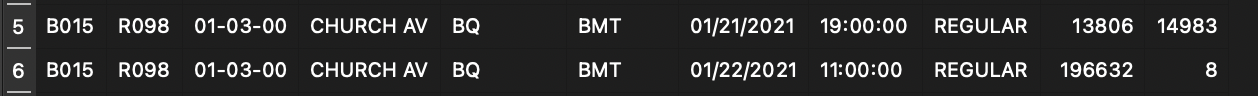

One of the reasons for outliers (based on 'Agg_enters' and 'Agg_exits' columns) is missing and faulty raw data. We are missing 3 records for the attached screenshot, and the 'Entries' and 'Exits' values don't make sense in the way that the cumulative numbers either jump drastically or fall drastically. 

I believe the best course of action, because this stems from the raw data, is to drop these rows with _extreme_ values (>40,000k agg_enter+exits). After checking ~100 rows of the data (random groups of 10) for validity in the 'Agg_enters' and 'Agg_exits' columns (manually comparing prior hour slot records, and doing the arithmetic by hand), it seems that the data not considered outliers are accurately calculated. 

Without filtering for these extreme outlier cases we have 270,849 records. After filtering for outliers (Aggregate enters+exits > 40,000) we get 270,838 records. 

In [217]:
station_daily = all_data[mask].groupby(['STATION', 'DOW', 'rush_hour', 'week_num', 'DOW1']).traffic.sum().reset_index()


In [218]:
station_daily.head()

,STATION,DOW,rush_hour,week_num,DOW1,traffic
0,1 AV,2021-01-04,Evening rush,1,Mon,4293
1,1 AV,2021-01-04,Morning rush,1,Mon,3546
2,1 AV,2021-01-05,Evening rush,1,Tue,4348
3,1 AV,2021-01-05,Morning rush,1,Tue,3694
4,1 AV,2021-01-06,Evening rush,1,Wed,4519


In [252]:
station_weekly = station_daily.groupby(['STATION', 'week_num', 'rush_hour']).traffic.sum().reset_index()

In [253]:
station_weekly['avg_traffic'] = station_weekly.groupby(['STATION','rush_hour']).traffic.transform(lambda x: x.mean())
station_weekly['traffic_change'] = station_weekly.groupby(['STATION', 'rush_hour']).traffic.diff()
station_weekly['avg_change'] =  station_weekly.groupby(['STATION','rush_hour']).traffic_change.transform(lambda x: x.mean())

In [260]:
station_total = station_weekly.groupby(['STATION', 'rush_hour']).agg({'traffic': 'sum',
                                                                      'avg_traffic': 'mean',
                                                                      'avg_change' : 'mean'
    
}).copy()

In [261]:
station_total.head()

traffic  avg_traffic  avg_change
STATION       rush_hour                                     
1 AV          Evening rush   232786      23278.6  353.111111
              Morning rush   194183      19418.3  303.666667
103 ST        Evening rush   267207      26720.7  381.333333
              Morning rush   118954      11895.4  172.333333
103 ST-CORONA Evening rush   290020      29002.0   91.444444

In [267]:
station_total['change_ranked'] =  station_total.groupby(['rush_hour']).avg_change.transform(lambda x: x.rank(ascending = False))
station_total['traffic_ranked'] =  station_total.groupby(['rush_hour']).avg_traffic.transform(lambda x: x.rank(ascending = False))


In [279]:
station_total['weighted_rank'] = (station_total['traffic_ranked'] * .75) + (station_total['change_ranked'] * .25)
station_total['final_rank'] =  station_total.groupby(['rush_hour']).weighted_rank.transform(lambda x: x.rank(ascending = True))

In [290]:
decile_top = round(max(station_total.final_rank)/10)
decile_bottom = max(station_total.final_rank) - decile_top

In [289]:
station_total[station_total['final_rank'] <= decile]

traffic  avg_traffic   avg_change  change_ranked  \
STATION        rush_hour                                                        
1 AV           Morning rush   194183      19418.3   303.666667           32.0   
103 ST         Evening rush   267207      26720.7   381.333333           44.0   
116 ST         Evening rush   290631      29063.1   516.111111           27.0   
125 ST         Evening rush   743170      74317.0  1066.333333            4.0   
               Morning rush   476570      47657.0   674.888889            6.0   
...                              ...          ...          ...            ...   
PATH NEW WTC   Morning rush   221513      22151.3   387.222222           22.0   
SUTPHIN-ARCHER Morning rush   217649      21764.9   224.888889           47.0   
TIMES SQ-42 ST Evening rush   571273      57127.3   691.444444           19.0   
               Morning rush   447452      44745.2   430.888889           15.0   
W 4 ST-WASH SQ Evening rush   261152      26115.2  1156.888889            3.0   

                             traffic_ranked  weighted_rank  final_rank  
STATION        rush_hour                                                
1 AV           Morning rush            38.0          36.50        34.0  
103 ST         Evening rush            39.0          40.25        37.0  
116 ST         Evening rush            33.0          31.50        28.0  
125 ST         Evening rush             4.0           4.00         3.0  
               Morning rush             9.0           8.25         7.0  
...                                     ...            ...         ...  
PATH NEW WTC   Morning rush            33.0          30.25        26.0  
SUTPHIN-ARCHER Morning rush            34.0          37.25        35.0  
TIMES SQ-42 ST Evening rush            13.0          14.50        12.5  
               Morning rush            10.0          11.25        10.0  
W 4 ST-WASH SQ Evening rush            44.0          33.75        30.0  

[76 rows x 7 columns]

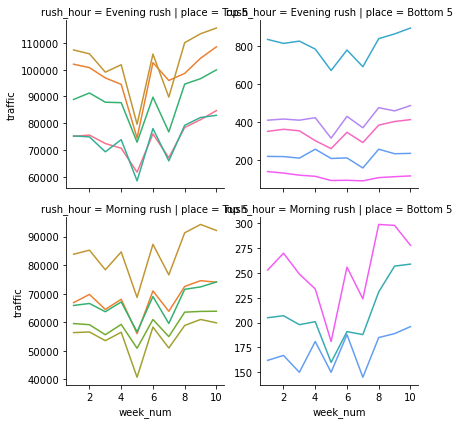

In [199]:
traffic_top = station_weekly[station_weekly['traffic_ranked'] < 6].copy()
traffic_bot = station_weekly[station_weekly['traffic_ranked'] > 373].copy()

traffic_top['place'] = 'Top 5'
traffic_bot['place'] = 'Bottom 5'

dfs = [traffic_top, traffic_bot]
plot_stations = pd.concat(dfs)

g = sns.FacetGrid(plot_stations, row = 'rush_hour', col = 'place', hue = 'STATION', sharey = False)
g.map(sns.lineplot, 'week_num', 'traffic');



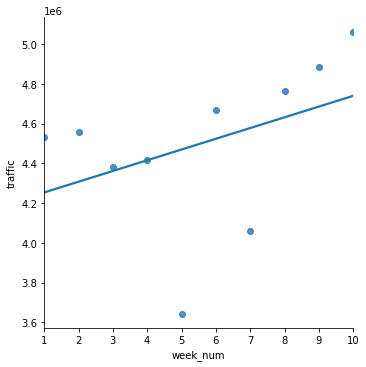

In [136]:
total_weekly = station_weekly.groupby('week_num').traffic.sum().reset_index()
# total_weekly.head()

sns.lmplot(x = 'week_num', y = 'traffic', data = total_weekly, ci = None);

# station_weekly[station_weekly['week_num'] == 5]

In [138]:

station_weekly['change_ranked'] =  station_weekly.groupby(['week_num','rush_hour']).traffic_change.transform(lambda x: x.rank(ascending = False))
station_weekly.head()

,STATION,week_num,rush_hour,traffic,traffic_ranked,traffic_change,change_ranked
0,1 AV,1,Evening rush,22512,50.0,NaN,NaN
1,1 AV,2,Evening rush,22938,49.0,426.0,51.0
2,1 AV,3,Evening rush,22587,48.0,-351.0,224.0
3,1 AV,4,Evening rush,23048,47.0,461.0,47.0
4,1 AV,5,Evening rush,19995,45.0,-3053.0,306.0


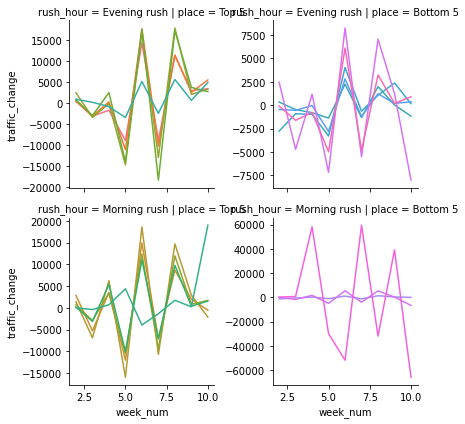

In [192]:
change_top = station_weekly[station_weekly['change_ranked'] < 6].copy()
change_bot = station_weekly[station_weekly['change_ranked'] > 373].copy()

change_top['place'] = 'Top 5'
change_bot['place'] = 'Bottom 5'

dfs = [change_top, change_bot]
plot_stations = pd.concat(dfs)

g = sns.FacetGrid(plot_stations, row = 'rush_hour', col = 'place', hue = 'STATION', sharey = False)
g.map(sns.lineplot, 'week_num', 'traffic_change');

In [144]:

station_weekly['avg_traffic_rank'] =  station_weekly.groupby(['STATION','rush_hour']).traffic_ranked.transform(lambda x: x.mean())
station_weekly['avg_change_rank'] =  station_weekly.groupby(['STATION','rush_hour']).change_ranked.transform(lambda x: x.mean())

In [146]:
station_weekly.head(30)

,STATION,week_num,rush_hour,traffic,traffic_ranked,traffic_change,change_ranked,avg_traffic_rank,avg_change_rank,avg_change
0,1 AV,1,Evening rush,22512,50.0,NaN,NaN,48.0,160.444444,353.111111
1,1 AV,2,Evening rush,22938,49.0,426.0,51.0,48.0,160.444444,353.111111
2,1 AV,3,Evening rush,22587,48.0,-351.0,224.0,48.0,160.444444,353.111111
3,1 AV,4,Evening rush,23048,47.0,461.0,47.0,48.0,160.444444,353.111111
4,1 AV,5,Evening rush,19995,45.0,-3053.0,306.0,48.0,160.444444,353.111111
5,1 AV,6,Evening rush,24098,50.0,4103.0,68.0,48.0,160.444444,353.111111
6,1 AV,7,Evening rush,21319,47.0,-2779.0,318.0,48.0,160.444444,353.111111
7,1 AV,8,Evening rush,24801,47.0,3482.0,46.0,48.0,160.444444,353.111111
8,1 AV,9,Evening rush,25798,47.0,997.0,31.0,48.0,160.444444,353.111111
9,1 AV,10,Evening rush,25690,50.0,-108.0,353.0,48.0,160.444444,353.111111


In [142]:
station_weekly.groupby('STATION').avg_traffic_rank.mean().sort_values()

STATION
34 ST-HERALD SQ      1.0
86 ST                2.0
34 ST-PENN STA       3.1
125 ST               4.6
GRD CNTRL-42 ST      4.9
                   ...  
BAY 50 ST          370.0
NEWARK C           370.3
BEACH 98 ST        372.0
BEACH 105 ST       373.0
BROAD CHANNEL      374.0
Name: avg_traffic_rank, Length: 374, dtype: float64

In [143]:
station_weekly.groupby('STATION').avg_change_rank.mean().sort_values()

STATION
ASTOR PL           119.444444
7 AV               127.111111
W 4 ST-WASH SQ     128.888889
96 ST              130.000000
14 ST              130.888889
                      ...    
CANARSIE-ROCKAW    229.444444
SUTPHIN BLVD       230.944444
MT EDEN AV         232.277778
ATL AV-BARCLAY     236.500000
JAMAICA 179 ST     242.166667
Name: avg_change_rank, Length: 374, dtype: float64

In [190]:
y = station_weekly.STATION.unique()
x = all_data.STATION.unique()
for a in x:
    if a not in y:
        print(a)

In [120]:
# mask = (all_data['STATION'] == '5 AV/53 ST')
# all_data[mask].head(30)